In [1]:
library(RBGL)
library(ggplot2)
library(dplyr)

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

Warning message:
“package ‘RBGL’ was built under R version 3.6.1”
Loading required package: graph

Warning message:
“package ‘graph’ was built under R version 3.6.1”
Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 3.6.1”
Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position,

In [2]:
directory <- "simresults"

In [3]:
dims <- c(80)
sample_sizes <- c(80, 160, 240, 400, 480, 640)
replicates <- c(20)

### Order MCMC

In [4]:
filenames <- list.files(pattern = "^(res_orderMCMC)", path = directory)
ROCdf_order_mcmc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“bi

In [5]:
sumROC_order_mcmc = ROCdf_order_mcmc %>%
                    filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%                    
                    group_by(algorithm, threshold, sample_size, dim) %>% 
                    summarise(TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              time = mean(time),
                              logscore_mean = mean(logscore),
                              N = n())%>%
                    filter(N %in% replicates)

### PC algorithm

In [6]:
filenames <- list.files(pattern = "^(res_pcalg)", path = directory)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [7]:
sum_roc_pcalg <- roc_pcalg %>% 
                 filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                 group_by(algorithm, alpha, sample_size, dim) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n()) %>% ungroup()%>%
                    filter(N %in% replicates)

### Max-Min hill climbing

In [8]:
filenames <- list.files(pattern = "^(res_mmhc)", path = directory)
roc_mmhc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_mmhc <- dplyr::bind_rows(roc_mmhc, tmpdf)
}

In [9]:
sum_roc_mmhc <- roc_mmhc %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                 group_by(algorithm, alpha, sample_size, dim) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n()) %>% ungroup()%>%
                    filter(N %in% replicates)

### Iterative MCMC

In [10]:
filenames <- list.files(pattern = "^(res_itsearch)", path = directory)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“bi

In [11]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                 group_by(algorithm, sample_size, dim) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          logscore_mean =  mean(logscore),
                          N = n())%>%
                    filter(N %in% replicates)

### Blip

In [12]:
filenames <- list.files(pattern = "^(res_blip)", path = directory)
ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

In [13]:
sum_roc_blip <- ROCdf_blip %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                 group_by(algorithm, sample_size, dim, time) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n())%>%
                    filter(N %in% replicates)

### GoBNiLP

In [14]:
filenames <- list.files(pattern = "^(res_gobnilp)", path = directory)
ROCdf_gobnilp <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_gobnilp <- dplyr::bind_rows(ROCdf_gobnilp, tmpdf)
}

In [15]:
sum_roc_gobnilp <- ROCdf_gobnilp %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                   group_by(algorithm, sample_size, dim) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n())%>%
                    filter(N %in% replicates)

## Plot ROC curves

In [34]:
setEPS()
postscript(file.path(directory, "ROC.eps"))

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



null device 
          1

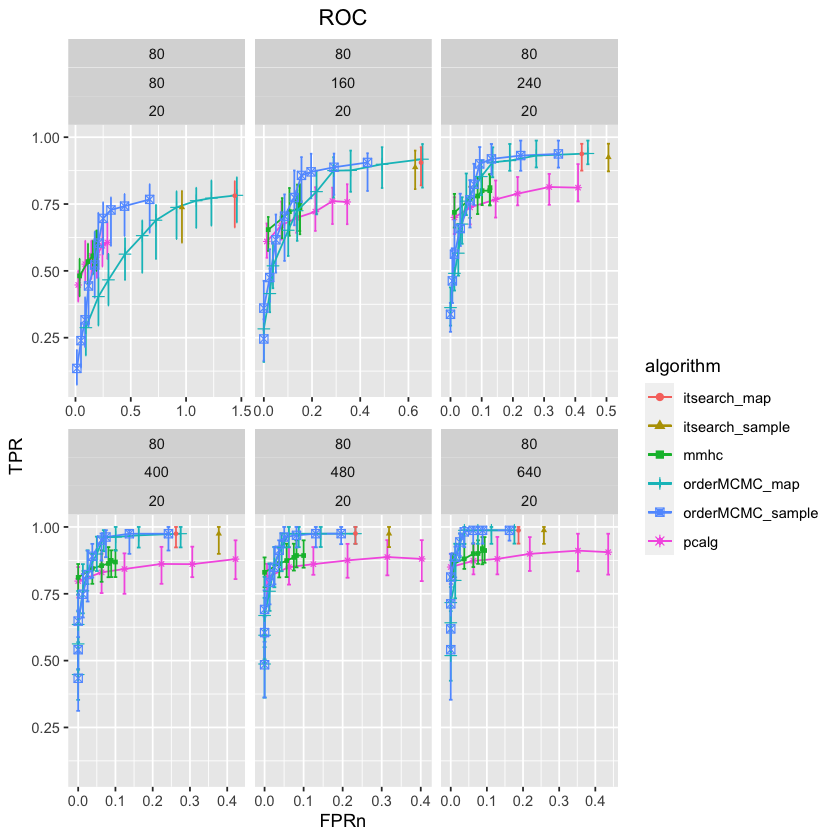

In [16]:

ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
# geom_text(data = sum_roc_pcalg,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=algorithm),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Max-min hill- climbing 
geom_errorbar(data = sum_roc_mmhc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_mmhc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_mmhc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
# geom_text(data = sum_roc_mmhc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=algorithm),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 2) +
# geom_text(data = sumROC_order_mcmc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02) +

# Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Gobnilp
geom_errorbar(data = sum_roc_gobnilp,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_gobnilp,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_gobnilp,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
## Subplot
facet_wrap(dim ~ sample_size + N, scales="free_x") +
# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
dev.off()

## Logscores

Warning message:
“Removed 36 row(s) containing missing values (geom_path).”
Warning message:
“Removed 36 rows containing missing values (geom_point).”
Warning message:
“Removed 36 rows containing missing values (geom_text).”


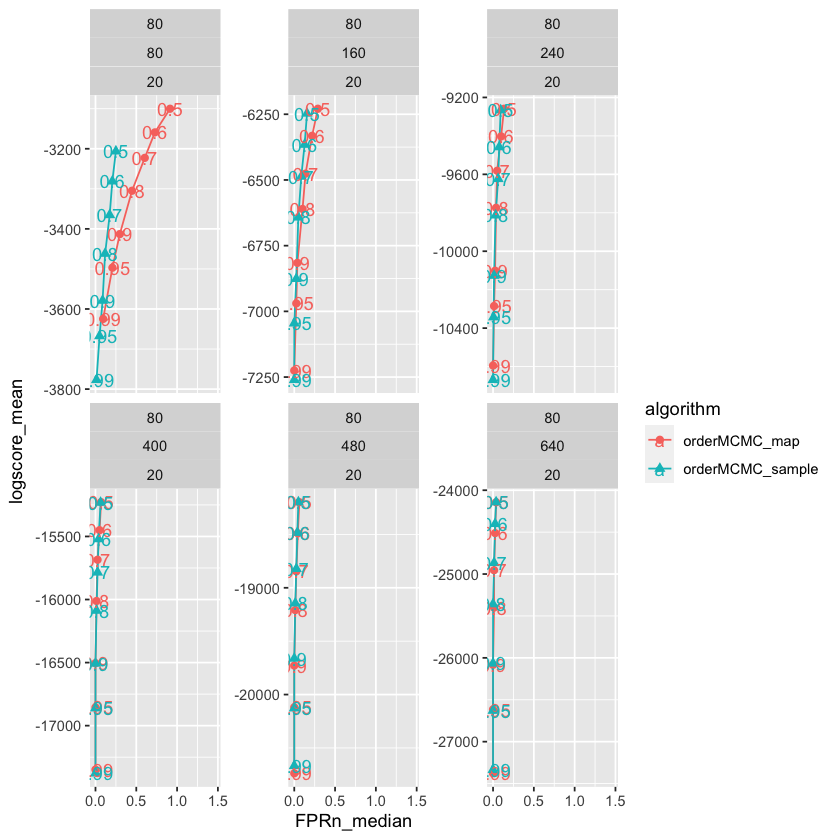

In [36]:
# Order mcmc
ggplot() + 
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = logscore_mean,
              col = algorithm)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = logscore_mean,               
               col = algorithm, 
               shape = algorithm), 
               size = 2) +
geom_text(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = logscore_mean,               
               col = algorithm, label=threshold)) +
facet_wrap(dim ~ sample_size + N, scales="free_y") 

Warning message:
“Removed 36 row(s) containing missing values (geom_path).”
Warning message:
“Removed 36 rows containing missing values (geom_point).”
Warning message:
“Removed 36 rows containing missing values (geom_text).”


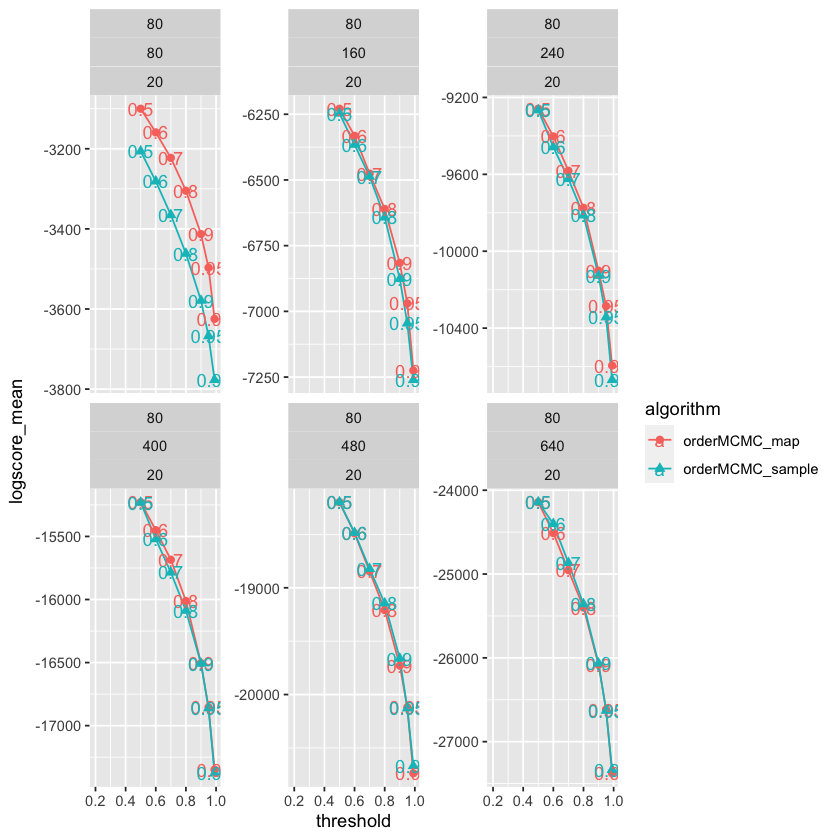

In [37]:
# Order mcmc
ggplot() + 
geom_path(data = sumROC_order_mcmc,
          aes(x = threshold, 
              y = logscore_mean,
              col = algorithm)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = threshold, 
               y = logscore_mean,               
               col = algorithm, 
               shape = algorithm), 
               size = 2) +
geom_text(data = sumROC_order_mcmc,
           aes(x = threshold, 
               y = logscore_mean,               
               col = algorithm, 
               label=threshold)) +
facet_wrap(dim ~ sample_size + N, scales="free_y") 

### SHD